In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
%matplotlib notebook

### Load data

In [3]:
path = '/Users/blandt/Desktop/Data/Rundowns/Par2 rundown Neon Jan 2020'
direcs = direcslist(path, 1)
lines = [p.strip('/').split('/')[-2].split('_')[1] for p in direcs]
lines_dict = {'lp637': 'Wild type', 'n2': 'N2', 'nwg201': 'Wild type, par-3 -/-', 'nwg240': 'C56S', 
              'nwg246': 'C56S, par-3 -/-'}
genotypes = [lines_dict[l] for l in lines]
conditions = [p.strip('/').split('/')[-2].split('_')[2] for p in direcs]

imgs = [load_image(p + '/af_corrected.tif') for p in direcs]
imgs_raw = [load_image(glob.glob(p + '/*488 SP 535-50*')[0]) for p in direcs]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in direcs]

cytbg = np.loadtxt('../PAR2 GFP mutants 1/cytbg.txt')
membg = np.loadtxt('../PAR2 GFP mutants 1/membg.txt')

### Run quantification

In [4]:
iq = ImageQuant(imgs, roi=rois, iterations=1, thickness=50, cytbg=cytbg, membg=membg, descent_steps=350, 
                uni_cyt=True, nfits=100, lr=0.01, interp_type='linear')

In [5]:
iq.run()

100%|██████████| 350/350 [01:35<00:00,  3.67it/s]


Time elapsed: 98.37 seconds 


<IPython.core.display.Javascript object>


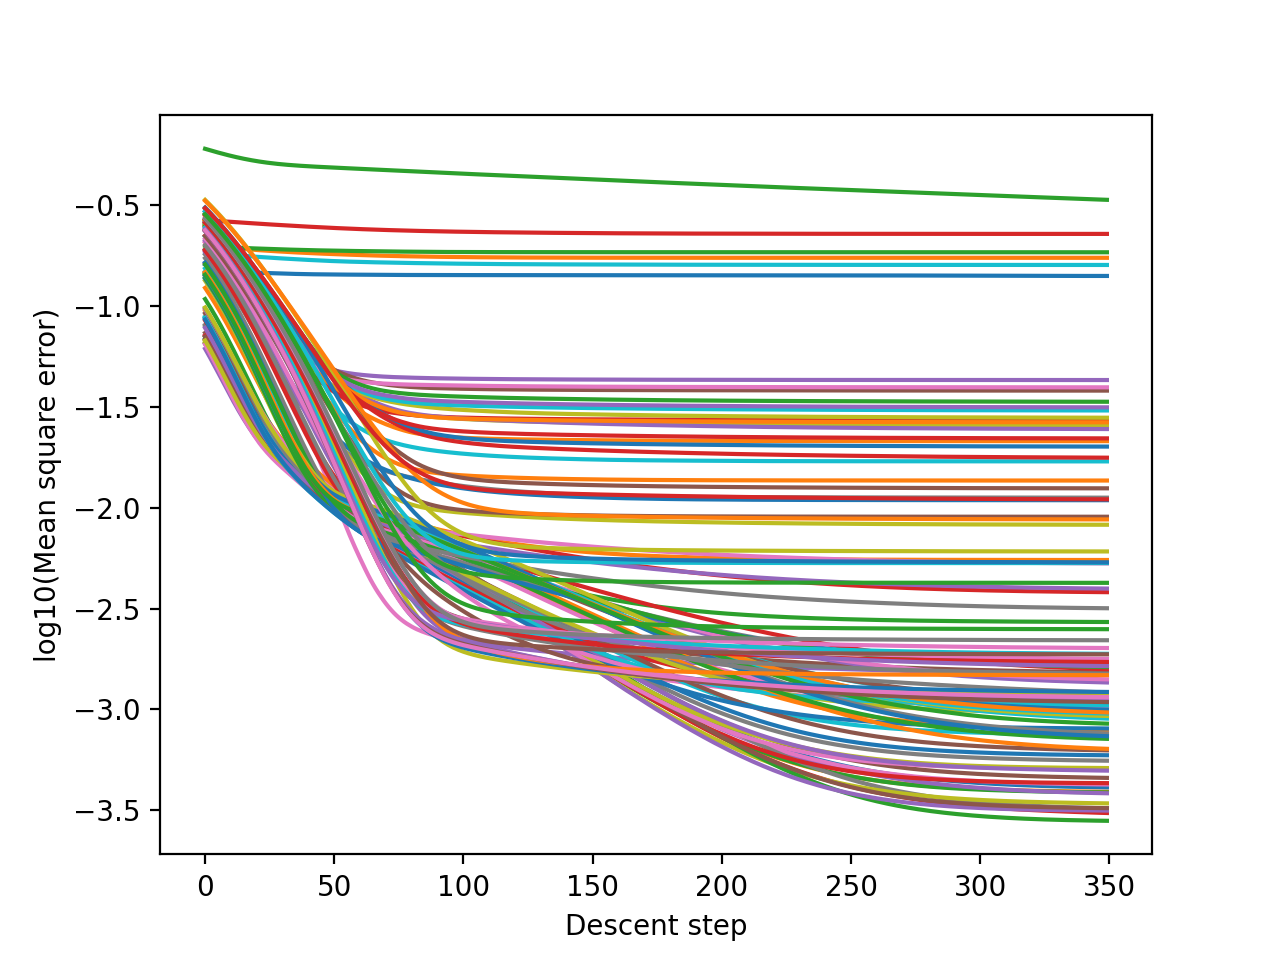

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [6]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


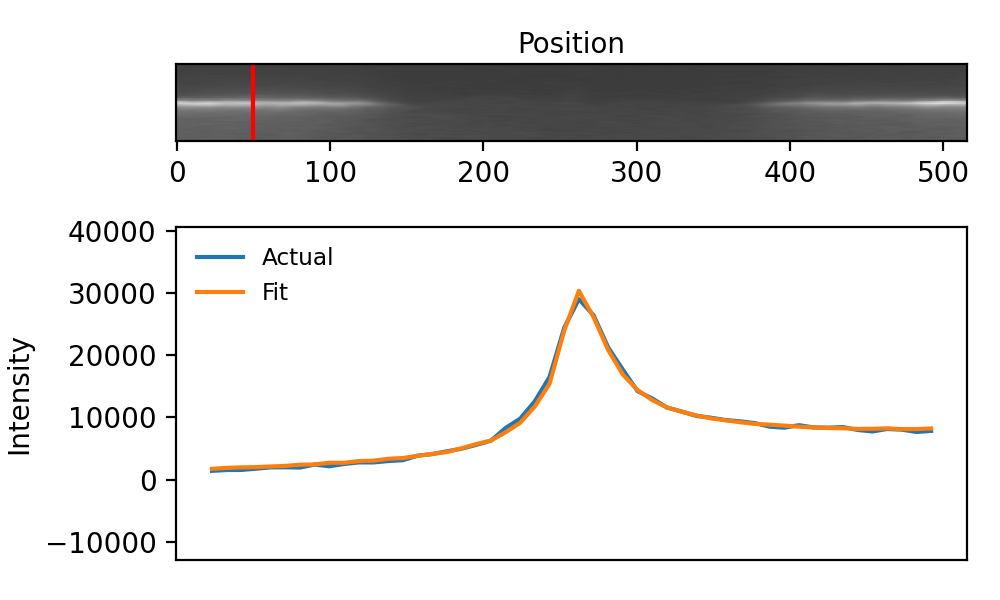

interactive(children=(IntSlider(value=0, description='Frame', max=106), FloatSlider(value=0.1, description='Po…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [7]:
iq.plot_fits(jupyter=True)

### Compile

In [8]:
res = iq.compile_res()
res['Membrane signal'] = res['Membrane signal'] * 2.703889975912648
res.to_csv('res.csv')
# print(res)

In [9]:
from datetime import datetime, timedelta

res = pd.read_csv('res.csv')
res_grouped = res.groupby('Frame')
n2_dosage = np.mean([dosage(i, r, 5) for i, r, c in zip(imgs_raw, rois, lines) if c == 'n2'])
print(n2_dosage)

df = pd.DataFrame()
for i, r in res_grouped:
#     d = direcs[i]
#     date_time = readnd(glob.glob(d + '/*.nd')[0])['StartTime1']
#     date = date_time.split(' ')[0]
#     time = date_time.split(' ')[1]   

    dosage_n2_sub = dosage(imgs_raw[i], rois[i], 5) - n2_dosage
    dosage_af = dosage(imgs[i], rois[i], 5)
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1])
    
#     if conditions[i] == 'wt':
#         rnai = 0.
#     else:
#         rnai_off = datetime.strptime(date_time, '%Y%m%d %H:%M:%S')
#         rnai_on = datetime.strptime(p['Condition'].split('p')[0], '%y%m%d%H%M')
#         rnai = (rnai_off - rnai_on).total_seconds() / (60 ** 2)
        
    p = {'ID': i, 'Line': lines[i], 'Condition': conditions[i], 'Path': direcs[i], 'Cyt': cyt, 'Mem_tot': mem_tot, 
         'Mem_ant': mem_ant, 'Mem_post': mem_post, 'Dosage_sub': dosage_n2_sub, 'Dosage_af': dosage_af,
        'Genotype': genotypes[i]} 
        
    df = df.append(pd.DataFrame(p, index=[i]))
    
df.to_csv('df.csv')

4625.337872234905
